This notebook contains the code and visualizations for the Statistical Data Analysis phase of the Predicting Water Pump Status project.

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from collections import Counter
from pylab import savefig
from datetime import datetime
from scipy.stats import spearmanr
from scipy.stats import entropy
from scipy.stats import chi2_contingency 

# custom functions 
from ml_support_functions import factorize_objects

In [2]:
def correlation_matrix(df_to_test):
    """inputs: pandas dataframe containing numeric data
       returns: correlation matrix between features in dataframe
    """

    columns = df_to_test.columns
    corr = pd.DataFrame(index=columns, columns=columns)
    for i in range(0,len(columns)):
        for j in range(i,len(columns)):
            if i == j:
                corr[columns[i]][columns[j]] = 1.0
            else:
                cell = cramers_v(df_to_test[columns[i]], df_to_test[columns[j]])
                corr[columns[i]][columns[j]] = cell
                corr[columns[j]][columns[i]] = cell
    corr.fillna(value=np.nan, inplace=True)
    return corr

In [3]:
def feature_correlations(df_to_test, threshold):
    """ inputs: pandas dataframe containing numeric data
        returns: dataframe of correlations greater than threshold between each feature
    """
    indep_list = []
    cols = df_to_test.columns
    results = np.empty(len(cols))
    for i in range(0,len(cols)):
        for j in range(i,len(cols)):
            if i == j:
                indep_list.append([cols[i], cols[j], 1, 1, 1])
            else:
                result_s = spearmanr(df_to_test[cols[i]], df_to_test[cols[j]])
                result_v = cramers_v(df_to_test[cols[i]], df_to_test[cols[j]])
                confusion_matrix = pd.crosstab(df_to_test[cols[i]],df_to_test[cols[j]])
                chi2_pvalue = chi2_contingency(confusion_matrix)[1]
                indep_list.append([cols[i], cols[j], result_s[0], result_s[1], result_v, chi2_pvalue])
    
    df_v = pd.DataFrame(indep_list, columns=['feature 1', 'feature 2', 'S correlation', 'S pvalue', 'C-V correlation', 'chi2 pvalue'])
    df_v.sort_values(by=['C-V correlation'], inplace=True, ascending=False)

    df_v = df_v[np.logical_and(df_v['C-V correlation']>threshold, df_v['C-V correlation']<1.0)]
    return df_v


In [4]:
def cramers_v(x, y):
	"""inputs: two numeric, nominal values, x and y
	   returns: correlation between x and y using Cramer's V approach
	"""
	confusion_matrix = pd.crosstab(x,y)
	chi2 = chi2_contingency(confusion_matrix)[0]
	n = confusion_matrix.sum().sum()
	phi2 = chi2/n
	r,k = confusion_matrix.shape
	phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
	rcorr = r-((r-1)**2)/(n-1)
	kcorr = k-((k-1)**2)/(n-1)
	return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

In [5]:
#initialize run parameters

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)
              
#The plots have to be made with large fonts to be legible
#when imported into a Google doc
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 18}

plt.rc('font', **font)

#for applying singly if using default style
text_size = 18

In [6]:
#read in the dataframes created after data wrangling
df_low_var = pd.read_csv('low_var.csv') 
df_high_var = pd.read_csv('high_var.csv') 


In [7]:
df_low_var.drop(columns=['Unnamed: 0'], axis=1, inplace=True)
df_low_var_f = factorize_objects(df_low_var)

#unfortunately the latitude and longitude values overload the Cramer's V function 
df_high_var.drop(columns=['Unnamed: 0', 'latitude', 'longitude'], axis=1, inplace=True)
df_high_var_f = factorize_objects(df_low_var)

## Q1: Are there strong correlations between independent variables, and does that change with cardinality?

To answer this question, we will run a test that evaluates correlation between nominal variables, Cramer's V, on both the low-variance and high-variance datasets.

In [8]:
df_to_test = df_low_var_f
df_low_var_corr = feature_correlations(df_to_test, 0.1)
df_low_var_corr

,feature 1,feature 2,S correlation,S pvalue,C-V correlation,chi2 pvalue
8,basin,region,0.118191,9.969647e-184,0.767069,0.000000e+00
32,extraction_type_class,waterpoint_type,0.639771,0.000000e+00,0.687645,0.000000e+00
30,extraction_type_class,source,0.320566,0.000000e+00,0.537535,0.000000e+00
74,source,waterpoint_type,0.243146,0.000000e+00,0.488648,0.000000e+00
69,region,source,0.137141,3.086934e-247,0.431358,0.000000e+00
...,...,...,...,...,...,...
15,construction_year,management_group,0.113794,2.254844e-170,0.125794,0.000000e+00
73,source,status_group,0.061356,1.199549e-50,0.121697,0.000000e+00
40,gps_height,status_group,-0.095240,1.020289e-119,0.109527,2.049663e-40
28,extraction_type_class,quantity,0.041086,1.277520e-23,0.104435,0.000000e+00


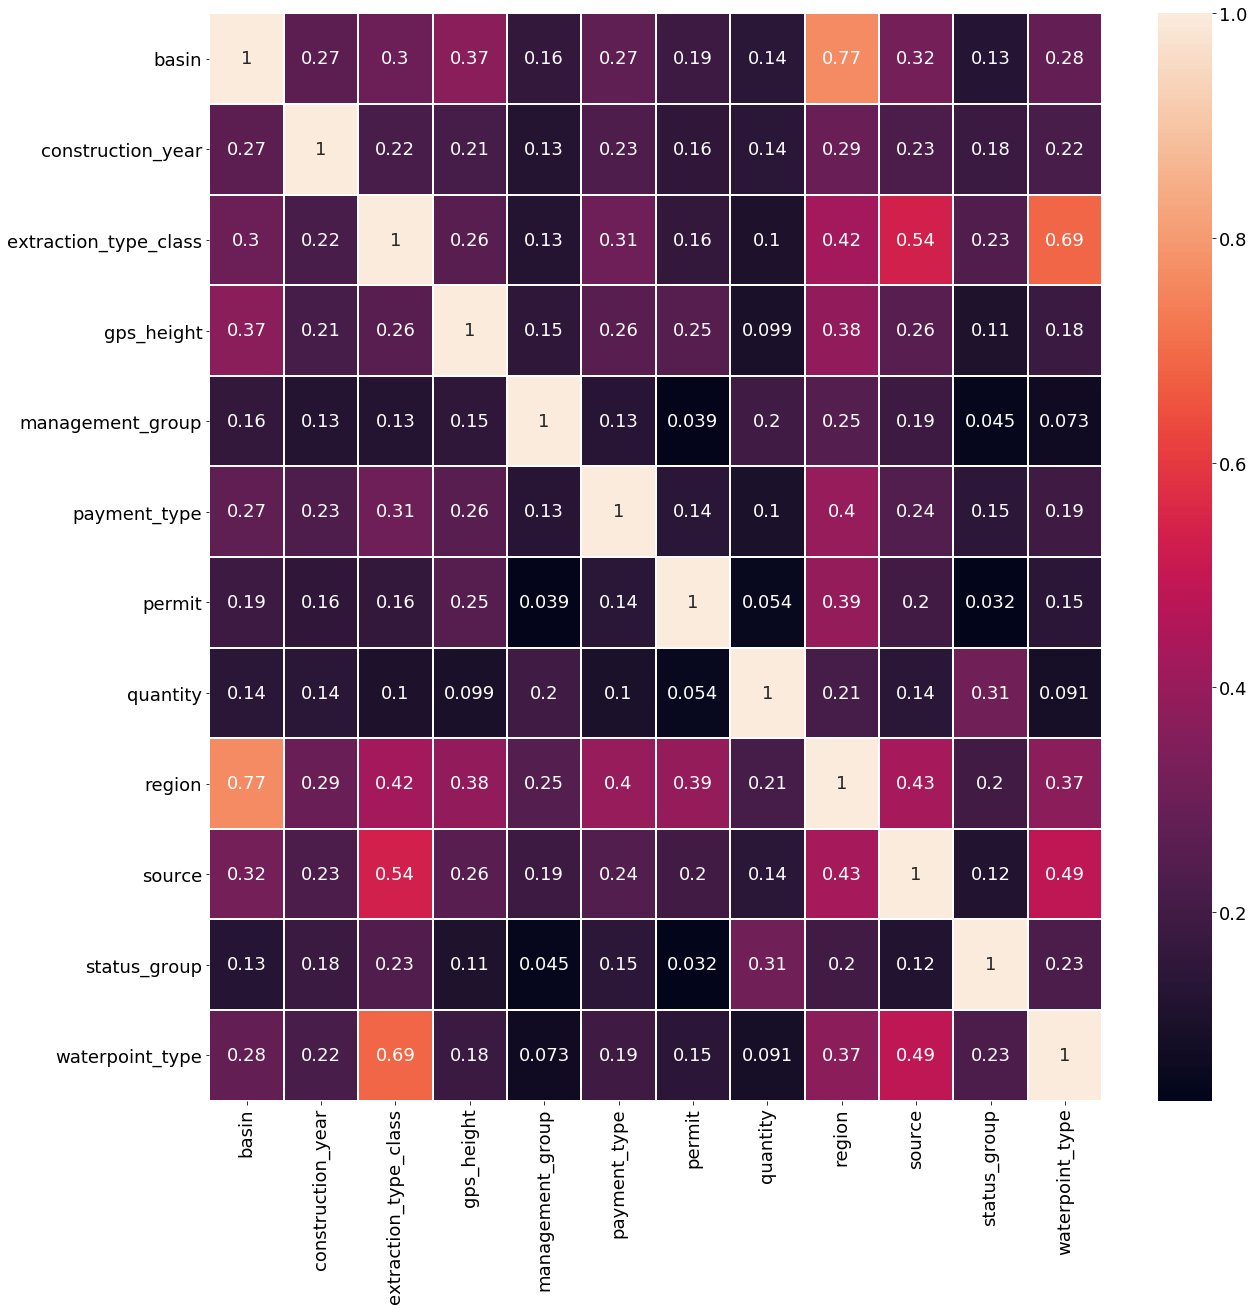

In [10]:
corr = correlation_matrix(df_low_var_f)
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20,20), sharex = True)
sns.heatmap(corr,annot=True, linecolor='white', linewidths=1)
plt.show()
          

These results on the low-variance dataset shows a strong correlation between basin and region.  This makes sense, as pumps in the same region would draw from the same basin. There is also a strong correlation between extraction type class and waterpoint type, underscoring the repetition of some of the same data points in the two features. 

Of all the features, region had the most correlations with other features. This suggests there are substantial differences among the regions of Tanzania, since as the region changes, so the other features change. This makes sense in a country as diverse as Tanzania, which contains the plains of Serengeti National Park, the mountains of Kilimanjaro National Park, and a coastline close to tropical islands. 

Of interest, there is also a correlation between the extraction type class and the source, revealing that certain types of pumps are used in certain types of sources. This is probably common knowledge among pump installers, but it takes statistical analysis to identify that point to those with less contextual knowledge about the data.

In [13]:
df_to_test = df_high_var_f
df_high_var_corr = feature_correlations(df_to_test, 0.01)
df_high_var_corr

,feature 1,feature 2,S correlation,S pvalue,C-V correlation,chi2 pvalue
8,basin,region,0.118191,9.969647e-184,0.767069,0.000000e+00
32,extraction_type_class,waterpoint_type,0.639771,0.000000e+00,0.687645,0.000000e+00
30,extraction_type_class,source,0.320566,0.000000e+00,0.537535,0.000000e+00
74,source,waterpoint_type,0.243146,0.000000e+00,0.488648,0.000000e+00
69,region,source,0.137141,3.086934e-247,0.431358,0.000000e+00
...,...,...,...,...,...,...
49,management_group,waterpoint_type,-0.083811,4.703079e-93,0.073014,1.229568e-200
58,permit,quantity,0.007112,8.304412e-02,0.053883,4.300364e-37
48,management_group,status_group,-0.028938,1.737070e-12,0.044694,1.109374e-49
44,management_group,permit,-0.001738,6.718378e-01,0.038921,5.018663e-20


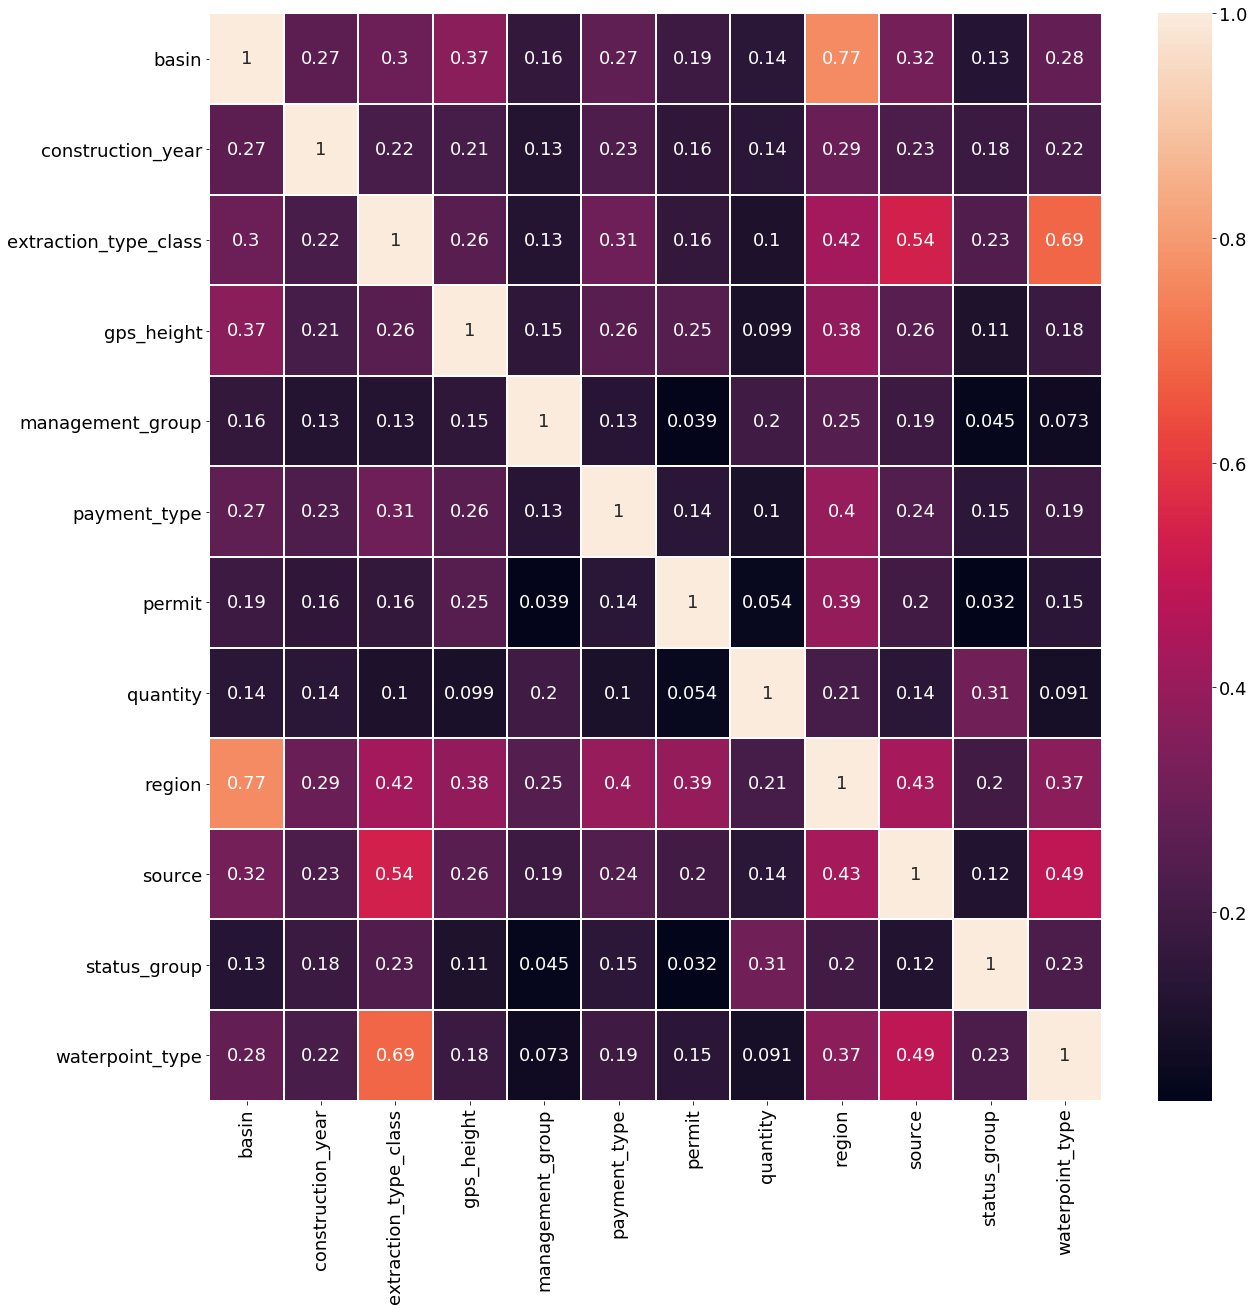

In [16]:
corr = correlation_matrix(df_high_var_f)
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20,20), sharex = True)
sns.heatmap(corr,annot=True, linecolor='white', linewidths=1)
plt.show()
          

The analysis of correlation on the high-variance dataset also shows a strong correlation between basin and region, this time using a feature, region_code, that had more variability. Interestingly, the correlations between region and other features are present but not as strong as in the low-variance dataset. 

The same phenomenon appears with extraction type and waterpoint type. The correlation is present but not as strong as in the low-variance dataset. 

This change in correlation might imply that the low-variance dataset would be the better dataset for creating the machine learning models.  

## Q2: Are there strong correlations between independent and target variables, and does that change with cardinality?

The features in the high-variance dataset show slightly higher correlation to the target than the features in the low-variance dataset.

It will be interesting to see which of these datasets produces better models when predicting in the machine learning phase.

## Q3: Does the strength of the correlations change with an asymetrical evaluation? 

In [17]:
# thank you: https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9
    
def conditional_entropy(x, y):
    """
    Calculates the conditional entropy of x given y: S(x|y)
    Wikipedia: https://en.wikipedia.org/wiki/Conditional_entropy
    **Returns:** float
    Parameters
    ----------
    x : list / NumPy ndarray / Pandas Series
        A sequence of measurements
    y : list / NumPy ndarray / Pandas Series
        A sequence of measurements
    nan_strategy : string, default = 'replace'
        How to handle missing values: can be either 'drop' to remove samples with missing values, or 'replace'
        to replace all missing values with the nan_replace_value. Missing values are None and np.nan.
    nan_replace_value : any, default = 0.0
        The value used to replace missing values with. Only applicable when nan_strategy is set to 'replace'.
    """

    y_counter = Counter(y)
    xy_counter = Counter(list(zip(x,y)))
    total_occurrences = sum(y_counter.values())
    entropy = 0.0
    for xy in xy_counter.keys():
        p_xy = xy_counter[xy] / total_occurrences
        p_y = y_counter[xy[1]] / total_occurrences
        entropy += p_xy * math.log(p_y/p_xy)
    return entropy


In [18]:
#official, full version
def theils_u(x, y):
    """
    Calculates Theil's U statistic (Uncertainty coefficient) for categorical-categorical association.
    This is the uncertainty of x given y: value is on the range of [0,1] - where 0 means y provides no information about
    x, and 1 means y provides full information about x.
    This is an asymmetric coefficient: U(x,y) != U(y,x)
    Wikipedia: https://en.wikipedia.org/wiki/Uncertainty_coefficient
    **Returns:** float in the range of [0,1]
    Parameters
    ----------
    x : list / NumPy ndarray / Pandas Series
        A sequence of categorical measurements
    y : list / NumPy ndarray / Pandas Series
        A sequence of categorical measurements
    nan_strategy : string, default = 'replace'
        How to handle missing values: can be either 'drop' to remove samples with missing values, or 'replace'
        to replace all missing values with the nan_replace_value. Missing values are None and np.nan.
    nan_replace_value : any, default = 0.0
        The value used to replace missing values with. Only applicable when nan_strategy is set to 'replace'.
    """
    
    s_xy = conditional_entropy(x,y)
    x_counter = Counter(x)
    total_occurrences = sum(x_counter.values())
    p_x = list(map(lambda n: n/total_occurrences, x_counter.values()))
    s_x = entropy(p_x)
    if s_x == 0:
        return 1
    else:
        return (s_x - s_xy) / s_x


In [19]:
df_theil_u_test = df_low_var_f

In [20]:
tu_list = []
cols = df_theil_u_test.columns
results = np.empty(len(cols))
for i in range(0,len(cols)):
    result_t = theils_u(df_theil_u_test['status_group'], df_theil_u_test[cols[i]])
    tu_list.append(['status_group', cols[i], result_t])
    
    result_t = theils_u(df_theil_u_test[cols[i]], df_theil_u_test['status_group'])
    tu_list.append([cols[i], 'status_group', result_t])
    
df_v = pd.DataFrame(tu_list, columns=['feature 1', 'feature 2', 'T-U'])
#df_v.sort_values(by=['T-U'], inplace=True, ascending=False)

print('Correlation Values')
df_v = df_v[np.logical_and(df_v['T-U']>0.10, df_v['T-U']<1.00)]
df_v

Correlation Values


,feature 1,feature 2,T-U
14,status_group,quantity,0.117611


In [21]:
df_theil_u_test = df_high_var_f

In [22]:
tu_list = []
cols = df_theil_u_test.columns
results = np.empty(len(cols))
for i in range(0,len(cols)):
    result_t = theils_u(df_theil_u_test['status_group'], df_theil_u_test[cols[i]])
    tu_list.append(['status_group', cols[i], result_t])
    
    result_t = theils_u(df_theil_u_test[cols[i]], df_theil_u_test['status_group'])
    tu_list.append([cols[i], 'status_group', result_t])
    
df_v = pd.DataFrame(tu_list, columns=['feature 1', 'feature 2', 'T-U'])
#df_v.sort_values(by=['T-U'], inplace=True, ascending=False)

print('Correlation Values')
df_v = df_v[np.logical_and(df_v['T-U']>0.10, df_v['T-U']<1.00)]
df_v

Correlation Values


,feature 1,feature 2,T-U
14,status_group,quantity,0.117611


Only the quantity feature showed a minimal asymmetric correlation, and this did not change between the high and low variance feature sets.